In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from glob import glob
import os

from math import pi

import json

from bokeh.io import output_notebook, show
from bokeh.palettes import Category20c
from bokeh.palettes import Spectral4
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models import Band
from bokeh.models import CategoricalColorMapper, Legend

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# Cassava Leaf Disease Classification EDA

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

## About Cassava

Cassava, Manihot esculenta, is a perennial shrub in the family Euphorbiaceae grown primarily for its storage roots which are eaten as a vegetable. The cassava plant is a woody plant with erect stems and spirally arranged simple lobed leaves with petioles (leaf stems) up to 30 cm in length. The plant produces petal-less flowers on a raceme. The edible roots of the plant are usually cylindrical and tapered and are white, brown or reddish in color. Cassava plants can reach 4 m in height and is usually harvested 9-12 months after planting. Cassava may also be referred to as Brazilian arrowroot, manioc, yuca or tapioca and the origins of the plant are unknown. The plant is not known to occur wild but may have first been cultivated in Brazil. Cassava is the third-largest source of food carbohydrates in the tropics, after rice and maize. It is a major staple food in the developing world, providing a basic diet for over half a billion people. It is one of the most drought-tolerant crops, capable of growing on marginal soils.[source](https://plantvillage.psu.edu/topics/cassava-manioc/infos/diseases_and_pests_description_uses_propagation)

## Explore Train and Test Datasets

Define the paths to the input data:

In [2]:
# Paths to the directiries with train and test datasets (images and tfrecords).
TRAIN_TFREC_DIR = '../input/cassava-leaf-disease-classification/train_tfrecords'
TEST_TFREC_DIR = '../input/cassava-leaf-disease-classification/test_tfrecords'
TRAIN_IMG_DIR = '../input/cassava-leaf-disease-classification/train_images'
TEST_IMG_DIR = '../input/cassava-leaf-disease-classification/test_images'

# Paths to the useful files with labels and sample submission.
LABELS_MAP_PATH = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
TRAIN_LABELS_PATH = '../input/cassava-leaf-disease-classification/train.csv'
SAMPLE_SUBMISSION_PATH = '../input/cassava-leaf-disease-classification/sample_submission.csv'

Load training labels:

In [3]:
train_df = pd.read_csv(TRAIN_LABELS_PATH)

train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Load the mapping of the labels to the deseases:

In [4]:
# Load the json file.
with open(LABELS_MAP_PATH, 'rb') as f:
    jsondata = json.load(f)
    
# Add labels from json file into dict.
labels_dict = {}
labels_dict[0] = jsondata['0']
labels_dict[1] = jsondata['1']
labels_dict[2] = jsondata['2']
labels_dict[3] = jsondata['3']
labels_dict[4] = jsondata['4']

labels_dict

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

Let's look how many images we have in total and how many images we have for each desease:

In [5]:
# See the example of pie chart implementation in bokeh:
# https://docs.bokeh.org/en/latest/docs/gallery/pie_chart.html?highlight=pie%20chart
def plot_pie_chart(data_dict, varname, title=''):
    """Plots the pie chart of the data in the dictionary."""

    data = pd.Series(data_dict).reset_index(name='value').rename(columns={'index': varname})
    data['angle'] = data['value']/data['value'].sum() * 2*pi
    data['color'] = Category20c[max(3,len(data_dict))][:len(data_dict)]

    p = figure(plot_height=350,
               plot_width=700,
               title=title, toolbar_location=None,
            tools="hover", tooltips="@{}: @value".format(varname))

    p.add_layout(Legend(), 'right')
    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', source=data, legend_field=varname)

    output_notebook()
    show(p)

In [6]:
# Gets the number of images in test folder.
test_fnames = glob(TEST_IMG_DIR+'*')

# Plots the pie chart with the number of train vs the number of test images (from the input folder).
plot_pie_chart({'train ({})'.format(len(train_df)):len(train_df),
                'test ({})'.format(len(test_fnames)):len(test_fnames)}, 'datasets', title='Train vs Test dataset size')

Loading BokehJS ...

In [7]:
# Generates the dictionary with the number of samples for each desease.
diseases_dict={}
for i in range(5):
    n_samples = len(train_df[train_df.label == i])
    diseases_dict[labels_dict[i]] = n_samples

# Plots the pie chart with the number of images for each desease.
plot_pie_chart(diseases_dict, 'datasets', title='Number of images for each desease')

Loading BokehJS ...

The dataset is imbalanced `Cassava Bacterial Blight (CBB)` is very rare compared to `Cassava Mosaic Disease (CMD)`. We may need to:
* Resample the dataset using different augmentations to include more samples from the underrepresented classes (for example, use weighted samplers). But be careful, resampling changes prior probabilities of the classes.
* Use weighted loss functions to assign more weight to samples from the undererpresented classes.

## Explore the Images

Let's visualize some examples of the images for different deseases:

In [8]:
def plot_image_examples(class_label_num, n_rows=3, n_cols=3):
    """Plots a grid with example of images for the specified class."""
    # Gets the label of the class.
    class_label = labels_dict[class_label_num]
    
    # Filter the images by label.
    label_df = train_df[train_df.label == class_label_num]
    
    # Random indices to plot.
    rand_idx = np.random.randint(0, len(label_df), n_rows*n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
    
    for row in range(n_rows):
        for col in range(n_cols):
            idx = rand_idx[row*n_cols + col]
            img_path = os.path.join(TRAIN_IMG_DIR, label_df.image_id.values[idx])
            img = Image.open(img_path)
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            axs[row, col].set_title(label_df.image_id.values[idx])
            
    plt.suptitle(class_label)
    plt.show()

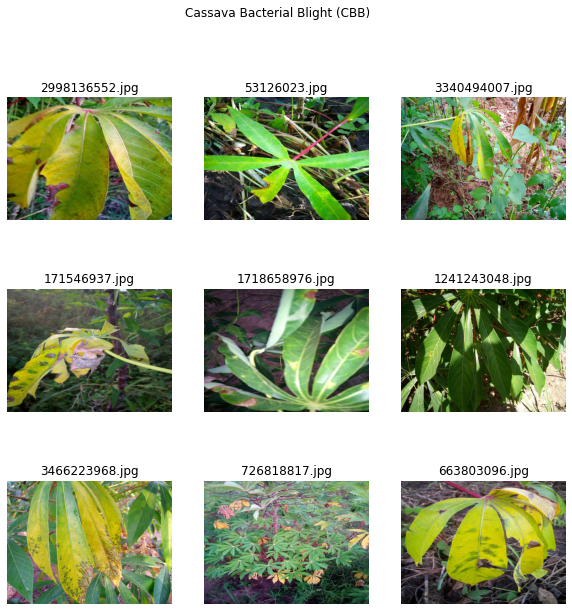

In [9]:
plot_image_examples(0)

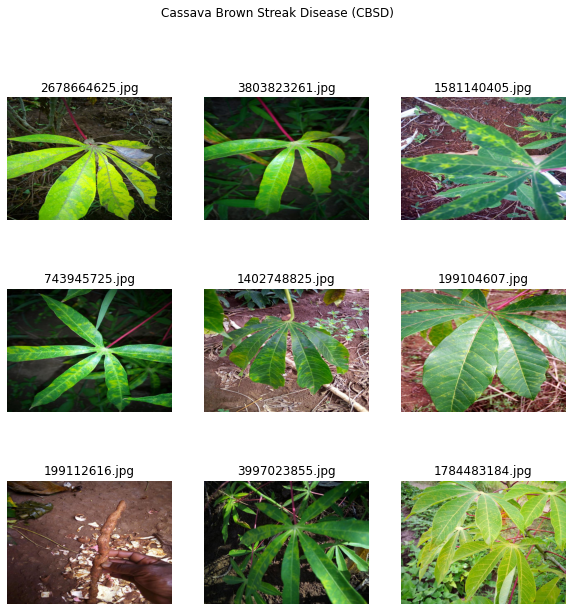

In [10]:
plot_image_examples(1)

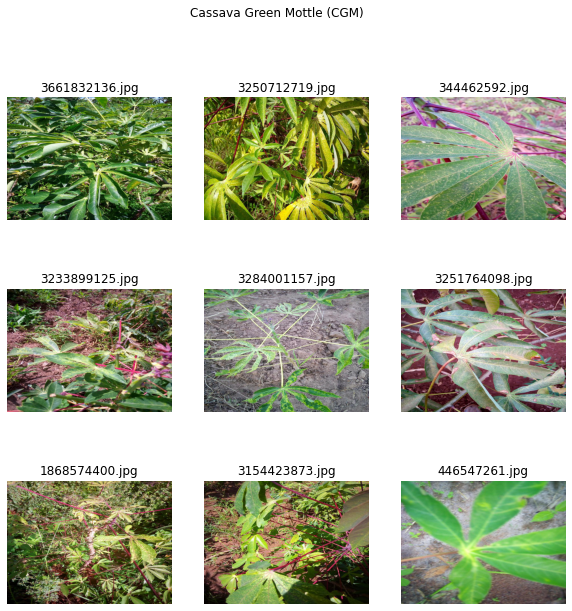

In [11]:
plot_image_examples(2)

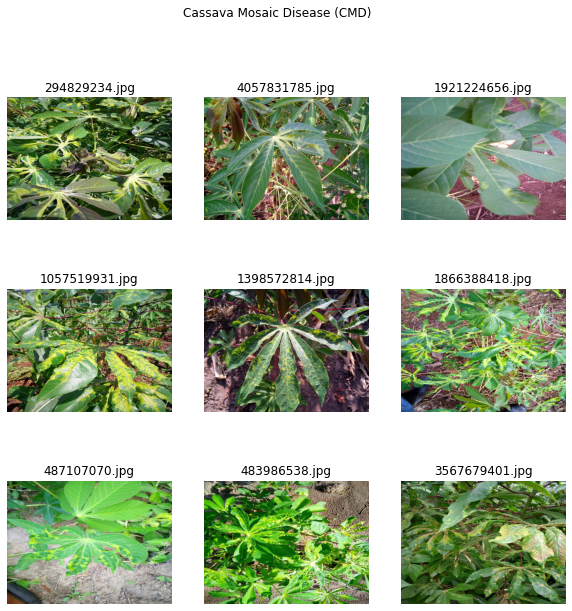

In [12]:
plot_image_examples(3)

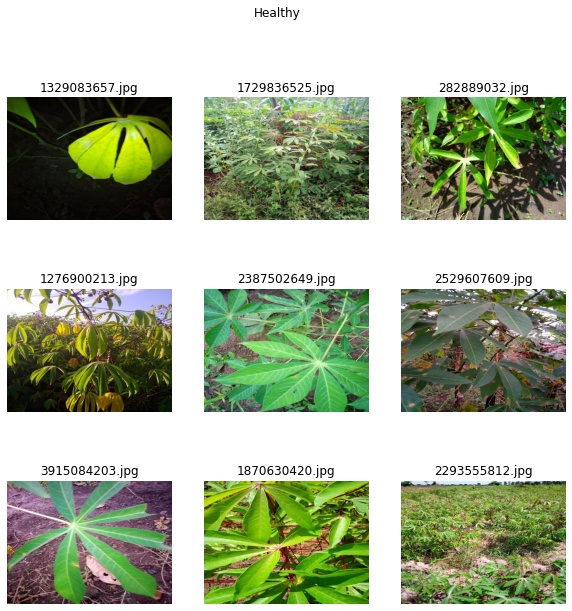

In [13]:
plot_image_examples(4)

The images are very interesting:
* Some of the images are taken in the fields, some of the images are taken at home (cassave leaves are just lying on a sheet of paper).
* Images have different lighting conditions. The model should account for that.
* The leaves are at different zoom levels. Sometimes the leaves are very far, so that even for human eyes it is hard to determine if there is something wrong with the plant.

## Related Papers and Repositories

### There are a lot of papers and github repositories that can actually help in this competition:
1. [Deep Learning for Image-Based Cassava Disease Detection](https://www.frontiersin.org/articles/10.3389/fpls.2017.01852/full): Using a dataset of cassava disease images taken in the field in Tanzania, we applied transfer learning to train a deep convolutional neural network to identify three diseases and two types of pest damage (or lack thereof). The best trained model accuracies were 98% for brown leaf spot (BLS), 96% for red mite damage (RMD), 95% for green mite damage (GMD), 98% for cassava brown streak disease (CBSD), and 96% for cassava mosaic disease (CMD). The best model achieved an overall accuracy of 93% for data not used in the training process. Our results show that the transfer learning approach for image recognition of field images offers a fast, affordable, and easily deployable strategy for digital plant disease detection.
2. [Plant Disease Detection Using Deep learning](https://arxiv.org/pdf/2003.05379v1.pdf), [code](https://github.com/abhinavsagar/plant-disease): Deep neural networks has been highly successful in image classification problems. In this paper, we show how neural networks can be used for plant disease recognition in the context of image classification. We have used publicly available Plant Village dataset which has 38 classes of diseases. Hence, the problem that we have addressed is a multi class classification problem. We compared five different architectures including VGG16, ResNet50, InceptionV3, InceptionResNet and DenseNet169 as the backbones for our work. We found that ResNet50 achieves the best result on the test set. For evaluation, we used metrics: accuracy, precision, recall, F1 score and class wise confusion metric. Our model achieves the best of results using ResNet50 with accuracy of 0.982, precision of 0.94, recall of 0.94 and F1 score of 0.94.
3. [The Plant Pathology 2020 challenge dataset to classify foliar disease of apples](https://arxiv.org/pdf/2004.11958v1.pdf), [code](https://github.com/CodingWitcher/Leaf_Diseases), [code](https://github.com/newbieeashish/Plant-Pathology-2020---FGVC7): Codes for [Kaggle Plant Pathology competition](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data).
4. [LeafGAN: An Effective Data Augmentation Method for Practical Plant Disease Diagnosis](https://arxiv.org/pdf/2002.10100v1.pdf), [code](https://github.com/IyatomiLab/LeafGAN): LeafGAN generates a wide variety of diseased images via transformation from healthy images, as a data augmentation tool for improving the performance of plant disease diagnosis. Thanks to its own attention mechanism, our model can transform only relevant areas from images with a variety of backgrounds, thus enriching the versatility of the training images.Experiments with ﬁve-class cucumber disease classiﬁcation show that data augmentation with vanilla CycleGAN cannot help to improve the generalization, i.e. disease diagnostic performance increased by only 0.7% from the baseline. In contrast, LeafGAN boosted the diagnostic performance by 7.4%. We also visually conﬁrmed the generated images by our LeafGAN were much better quality and more convincing than those generated by vanilla CycleGAN.

**The notebook is being updated. Your comments and questions are very welcome!**